## <span style="color:#3182bd"><center>**Extraer Informacion escrita a mano**</center></span>

## pasar pdf a imagen y recortarla

Como los pdf escaneados no tienen la misma estructura, debemos realizarle el siguiente proceso para que la información tenga una misma estructura:

1 extraemos la pagina necesaria y la convertimos en imagen

2 se pasa la imagen a escala de grises, se detectan los bords del formato y se realiza un recore a la imagen y se redimenciona



In [ ]:
#pip install google-cloud-vision  

In [34]:
import fitz  # PyMuPDF
import cv2
import numpy as np
import os


formatos_entrada = r"C:\Users\pc\OneDrive\Escritorio\OC_pdf\Formatos"
imagen_salida = r"C:\Users\pc\OneDrive\Escritorio\OC_pdf\carpeta_salida"
os.makedirs(imagen_salida, exist_ok=True)

pdf_lista = [f for f in os.listdir(formatos_entrada) if f.endswith(".pdf")]

for idx, pdf_file in enumerate(pdf_lista, start=1):

    pdf_path = os.path.join(formatos_entrada, pdf_file)
    pdf_documento = fitz.open(pdf_path)
    primer_pagina = pdf_documento.load_page(0)
    image = primer_pagina.get_pixmap(matrix=fitz.Matrix(300/72, 300/72))
    image_filename = f"pagina_{idx}.png"
    image_path = os.path.join(imagen_salida, image_filename)
    image.save(image_path, "png")
    pdf_documento.close()
    
    image = cv2.imread(image_path)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150, apertureSize=3)


    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    
    if lines is not None:
        mask = np.zeros(gray.shape, dtype=np.uint8)

        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            cv2.line(mask, (x1, y1), (x2, y2), 255, 2)

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)

            
            imagen_recortada = image[y:y + h, x:x + w]

            
            nuevo_ancho = 1629
            nuevo_alto = 1236
            imagen_recortada = cv2.resize(imagen_recortada, (nuevo_ancho, nuevo_alto))

           
            imagen_mejorada = cv2.filter2D(imagen_recortada, -1, np.array([[-1, -1, -1],
                                                                         [-1,  10, -1],
                                                                         [-1, -1, -1]]))

            
            nombre_imagen_mejorada = os.path.join(imagen_salida, image_filename)

           
            cv2.imwrite(nombre_imagen_mejorada, imagen_mejorada)

print("Procesamiento de PDFs completado.")


Procesamiento de PDFs completado.


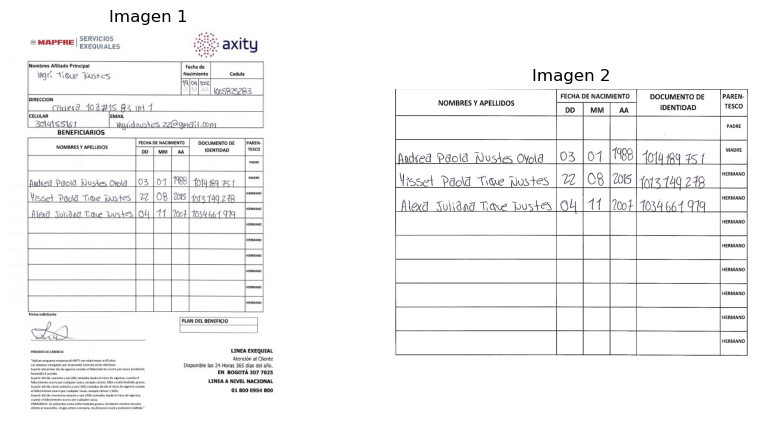

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = [
    r"C:\Users\pc\OneDrive\Escritorio\OC_pdf\imagen2.jpg",
    r"C:\Users\pc\OneDrive\Escritorio\OC_pdf\carpeta_salida\pagina_4.png"
]

num_images = len(image_paths)
fig, axes = plt.subplots(1, num_images, figsize=(10, 5))

# Cargar y mostrar las imágenes
for i, image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f'Imagen {i+1}')
    axes[i].axis('off')

plt.show()


In [86]:
from google.cloud import vision
from google.oauth2 import service_account
import io
import os

# Ruta al archivo JSON de credenciales de servicio
credentials_path = r"C:\Users\pc\OneDrive\Escritorio\OC_pdf\ocr-extraer-texto-c42de34459bc.json"

# Inicializa el cliente de Google Cloud Vision
credentials = service_account.Credentials.from_service_account_file(credentials_path)
client = vision.ImageAnnotatorClient(credentials=credentials)

# Directorio que contiene las imágenes a procesar
input_directory = r"C:\Users\pc\OneDrive\Escritorio\OC_pdf\carpeta_salida"

# Define las coordenadas de las regiones de interés (ROI) y asigna un identificador único
regiones = [
    {"id": 1, "left_x": 6, "top_y": 127, "right_x": 748, "bottom_y": 252},
    {"id": 2, "left_x": 740, "top_y": 128, "right_x": 1112, "bottom_y": 237},
    {"id": 3, "left_x": 1114, "top_y": 138, "right_x": 1500, "bottom_y": 259},
    {"id": 4, "left_x": 1500, "top_y": 138, "right_x": 1622, "bottom_y": 243},
    
    {"id": 5, "left_x": 6, "top_y": 236, "right_x": 748, "bottom_y": 360},
    {"id": 6, "left_x": 750, "top_y": 243, "right_x": 1107, "bottom_y": 359},
    {"id": 7, "left_x": 1114, "top_y": 256, "right_x": 1500, "bottom_y": 345},
    {"id": 8, "left_x": 1500, "top_y": 248, "right_x": 1622, "bottom_y": 357},
    
    {"id": 9, "left_x": 6, "top_y": 347, "right_x": 748, "bottom_y": 455},
    {"id": 10, "left_x": 743, "top_y": 352, "right_x": 1107, "bottom_y": 454},
    {"id": 11, "left_x": 1114, "top_y": 354, "right_x": 1500, "bottom_y": 462},
    {"id": 12, "left_x": 1500, "top_y": 355, "right_x": 1622, "bottom_y": 462}
]
lista = []
for image_file in os.listdir(input_directory):
    image_path = os.path.join(input_directory, image_file)

    # Lee la imagen
    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()

    # Crea una instancia de la imagen para Google Cloud Vision
    image = vision.Image(content=content)

    # Inicializa un diccionario para almacenar el texto por coordenadas
    texto_por_coordenadas = {}

    # Realiza la solicitud de OCR con Google Cloud Vision
    response = client.text_detection(image=image)
    texts = response.text_annotations

    # Procesa cada región de interés (ROI) y almacena el texto en el diccionario
    
    for region in regiones:
        region_id = region["id"]
        left_x, top_y, right_x, bottom_y = region["left_x"], region["top_y"], region["right_x"], region["bottom_y"]

        # Verifica si el texto está dentro de la región de interés
        texto_en_region = ""
        for text in texts:
            if left_x <= text.bounding_poly.vertices[0].x <= right_x and \
               top_y <= text.bounding_poly.vertices[0].y <= bottom_y:
                texto_en_region += text.description + " "

        texto_por_coordenadas[region_id] = texto_en_region.strip()

    # Imprime el texto por coordenadas para la imagen actual
    #print(f"Texto extraído de {image_file} por coordenadas:")
    
    for region_id, texto in texto_por_coordenadas.items():
    #    print(f"Región {region_id}: {texto}")
        lista.append(texto)


In [87]:
import pandas as pd


datos = lista


num_columnas = 4
datos_agrupados = [datos[i:i + num_columnas] for i in range(0, len(datos), num_columnas)]

column_names = ["nombre", "fecha_nacimiento","id","parentesco"]  # Nombres de las columnas
df = pd.DataFrame(datos_agrupados, columns=column_names)

df = df.drop(df.index[[12, 17]])

df = df.applymap(lambda x: x.rstrip() if isinstance(x, str) else x)

df['nombre'] = df['nombre'].astype(str)
df['parentesco'] = df['parentesco'].astype(str)

df['id'] = df['id'].str.replace(r'\D', '', regex=True)

df['fecha_nacimiento'] = df['fecha_nacimiento'].str.replace(r'[^\w\s]', '', regex=True)
df['fecha_nacimiento'] = df['fecha_nacimiento'].str.replace('p', '0')
df['fecha_nacimiento'] = df['fecha_nacimiento'].str.replace('  ', ' ')
df['fecha_nacimiento'] = df['fecha_nacimiento'].str.replace(' ', '-')

df

,nombre,fecha_nacimiento,id,parentesco
0,Angelica Vannessa Ramirez Rubio,11-12-92,1072667399,ESPOS @
1,German Reina Bojaca,11-03-59,2994376,SUEGR @ O PADRE
2,,,,SUEGR @ O MADRE
3,,,,ESPOS @
4,Lourian Eliseo Buitrago Rodríguez,12-02-1960,19392593,SUEGR @ O PADRE
5,Angie Carolina Cardozo,02-02-1979,52536718,SUEGR @ O MADRE
6,,,,PADRE
7,Andrea Paola Nustes Ovola,03-01-1988,1014189751,MADRE
8,lisset Paola Tique Nustes,22-08-2015,1013149278,HERMANO
9,Robén Dano Palacio Velasquez Lina,8-01-1982,71271344,PADRE
